<a href="https://colab.research.google.com/github/liviabelirocha/ia-ck0248/blob/main/mask_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import array_to_img

# Constantes

In [ ]:
img_size = (48,48) # Dimensões das imagens
batch_size = 32; # Lotes
val_split = 0.2 # Validação
path = "/content/drive/MyDrive/Colab Notebooks/IA/dataset/train"
seed = 42

Constantes utilizadas:


*   img_size: tamanho da imagem, em pixels;
*   batch_size: quantidade de arquivos a serem carregados em cada lote;
*   val_split: percentual utilizado para dividir o dataset em grupo de validação e grupo de treino;
*   path: caminho do dataset;
*   seed: valor utilizado para manter a consistência nos métodos de randomização.



# Treino

In [ ]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=val_split,
    subset="training",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    seed = seed,
)

Found 1135 files belonging to 2 classes.
Using 908 files for training.


Criação do subset pré-processado de treino. Pela variável val_split, temos que 20% do dataset será utilizado para o subset de validação e portanto, o subset de treino será o complementar (80% do dataset).

In [ ]:
classes = train.class_names
classes

['mask', 'no_mask']

# Validação

In [ ]:
validation = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=val_split,
    subset="validation",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    seed = seed,
)

Found 1135 files belonging to 2 classes.
Using 227 files for validation.


Criação do subset pré-processado de validação. Pela variável val_split, temos que 20% do dataset será utilizado para o subset de validação e portanto, o subset de validação irá conter 20% de todos os itens do dataset.

# Visualização

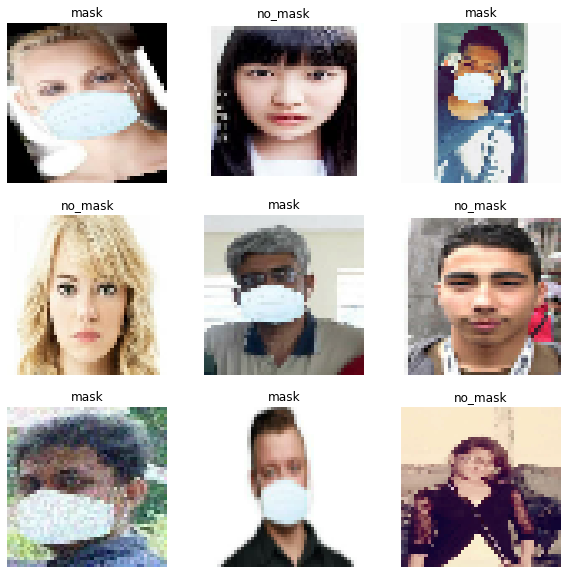

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(array_to_img(images[i]))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")

# Modificando as imagens

In [ ]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

augmented_training = train.map(lambda x , y:(data_augmentation(x, training = True), y))

augmented_training = augmented_training.prefetch(buffer_size=32)
validation = validation.prefetch(buffer_size=32)

Processo de melhoria do dataset. Utilizando rotações randômicas nas imagens, podemos criar um ambiente mais heterogêneo e completo para o processo de treino. 

# Construção dos models

## Accuracy

In [ ]:
model = keras.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))

Definição do modelo sequencial. Inicialmente são aplicados nas imagens um layer de convolução, seguido de um layer de Pooling cujo máximo é extraído. Ao repertirmos o processo algumas vezes, obtemos matrizes que resumem as propriedades gerais das imagens para serem utilizadas na rede neural.

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 32)          18464     
                                                                 
Total params: 37,856
Trainable params: 37,856
Non-tra

In [ ]:

model.add(layers.Flatten()) # Camada de entrada

model.add(layers.Dense(64, activation="relu")) # Camada oculta

model.add(layers.Dense(2, activation="softmax")) # Camada de saída, "softmax" é utilizada para saídas com muitas classes (array com multiplas probabilidades)

Aplainamento do modelo e aplicação dos nós densos da rede.

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 32)          18464     
                                                                 
 flatten_13 (Flatten)        (None, 2048)            

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) # Compilação do modelo; hiperparametros

In [ ]:
epochs = 20
history = model.fit(augmented_training, epochs=epochs, validation_data=validation)

Epoch 1/20
29/29 [==============================] - 6s 173ms/step - loss: 3.1137 - accuracy: 0.6861 - val_loss: 0.3348 - val_accuracy: 0.8590
Epoch 2/20
29/29 [==============================] - 6s 167ms/step - loss: 0.3219 - accuracy: 0.8811 - val_loss: 0.1656 - val_accuracy: 0.9295
Epoch 3/20
29/29 [==============================] - 6s 167ms/step - loss: 0.1983 - accuracy: 0.9317 - val_loss: 0.1335 - val_accuracy: 0.9339
Epoch 4/20
29/29 [==============================] - 6s 168ms/step - loss: 0.1774 - accuracy: 0.9317 - val_loss: 0.1195 - val_accuracy: 0.9515
Epoch 5/20
29/29 [==============================] - 5s 168ms/step - loss: 0.1480 - accuracy: 0.9438 - val_loss: 0.1431 - val_accuracy: 0.9427
Epoch 6/20
29/29 [==============================] - 6s 169ms/step - loss: 0.1741 - accuracy: 0.9328 - val_loss: 0.1836 - val_accuracy: 0.9251
Epoch 7/20
29/29 [==============================] - 6s 168ms/step - loss: 0.1518 - accuracy: 0.9438 - val_loss: 0.1297 - val_accuracy: 0.9427
Epoch 

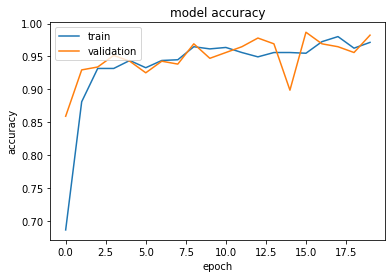

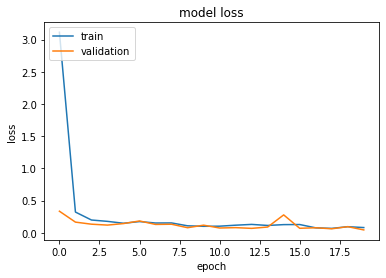

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/IA/dataset/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    seed=seed
)

Found 241 files belonging to 2 classes.


Criação do grupo de testes pré-processado.

In [ ]:
acc_names = model.metrics_names

In [ ]:
loss_acc, acc = model.evaluate(test_set)
print("loss: ", loss_acc)
print("accuracy: ", acc)

8/8 [==============================] - 1s 37ms/step - loss: 0.0700 - accuracy: 0.9834
loss:  0.06996378302574158
accuracy:  0.9834024906158447


## F1

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model_f1 = keras.Sequential()

model_f1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))

model_f1.add(layers.MaxPooling2D((2, 2)))

model_f1.add(layers.Conv2D(64, (3, 3), activation='relu'))

model_f1.add(layers.MaxPooling2D((2, 2)))

model_f1.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_f1.add(layers.Flatten()) # Camada de entrada

model_f1.add(layers.Dense(64,activation="relu")) # Camada oculta

model_f1.add(layers.Dense(2, activation="softmax")) # Camada de saída, "softmax" é utilizada para saídas com muitas classes (array com multiplas probabilidades)

In [ ]:
model_f1.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 8, 8, 32)          18464     
                                                                 
 flatten_14 (Flatten)        (None, 2048)            

In [ ]:
model_f1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_m])

In [ ]:
history_f1 = model_f1.fit(augmented_training, epochs=epochs, validation_data=validation)

Epoch 1/20
29/29 [==============================] - 6s 175ms/step - loss: 2.7731 - f1_m: 0.6254 - val_loss: 0.5789 - val_f1_m: 0.7070
Epoch 2/20
29/29 [==============================] - 6s 170ms/step - loss: 0.3696 - f1_m: 0.8603 - val_loss: 0.2472 - val_f1_m: 0.9297
Epoch 3/20
29/29 [==============================] - 6s 169ms/step - loss: 0.1955 - f1_m: 0.9332 - val_loss: 0.0821 - val_f1_m: 0.9349
Epoch 4/20
29/29 [==============================] - 6s 169ms/step - loss: 0.1538 - f1_m: 0.9483 - val_loss: 0.0777 - val_f1_m: 0.9310
Epoch 5/20
29/29 [==============================] - 6s 167ms/step - loss: 0.1186 - f1_m: 0.9594 - val_loss: 0.0639 - val_f1_m: 0.9805
Epoch 6/20
29/29 [==============================] - 6s 167ms/step - loss: 0.1044 - f1_m: 0.9698 - val_loss: 0.0605 - val_f1_m: 0.9805
Epoch 7/20
29/29 [==============================] - 6s 166ms/step - loss: 0.1029 - f1_m: 0.9659 - val_loss: 0.0357 - val_f1_m: 0.9961
Epoch 8/20
29/29 [==============================] - 5s 166ms/s

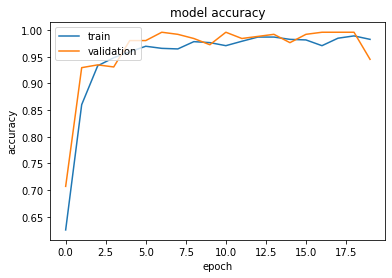

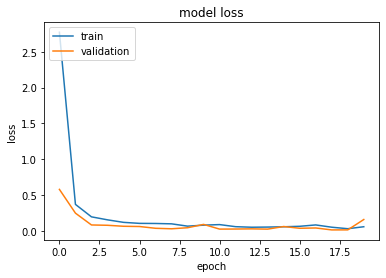

In [ ]:
plt.plot(history_f1.history['f1_m'])
plt.plot(history_f1.history['val_f1_m'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history_f1.history['loss'])
plt.plot(history_f1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
f1_names = model_f1.metrics_names

In [ ]:
loss_f1, f1 = model_f1.evaluate(test_set)
print("loss: ", loss_f1)
print("f1: ", f1)

8/8 [==============================] - 1s 32ms/step - loss: 0.2928 - f1_m: 0.9336
loss:  0.29280397295951843
f1:  0.93359375


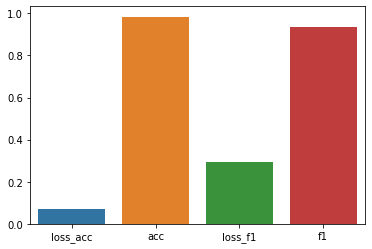

In [ ]:
all_values = [loss_acc, acc, loss_f1, f1]
all_names = ["loss_acc", "acc", "loss_f1", "f1"]

graph = sns.barplot(x=all_names, y=all_values)

In [ ]:
model.save(f"/content/drive/MyDrive/Colab Notebooks/IA/dataset/model_{img_size[0]}-{epochs}.h5")

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/IA/dataset/model_24-20.h5")

# Outras configurações

## Novas Constantes

In [ ]:
img_size = (24,24) # Dimensões das imagens
batch_size = 32; # Lotes
val_split = 0.2 # Validação
path = "/content/drive/MyDrive/Colab Notebooks/IA/dataset/train"
seed = 42

## Novo treino

In [ ]:
train_new = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=val_split,
    subset="training",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    seed = seed,
)

Found 1135 files belonging to 2 classes.
Using 908 files for training.


## Nova validação

In [ ]:
validation_new = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=val_split,
    subset="validation",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    seed = seed,
)

Found 1135 files belonging to 2 classes.
Using 227 files for validation.


## Nova Visualização

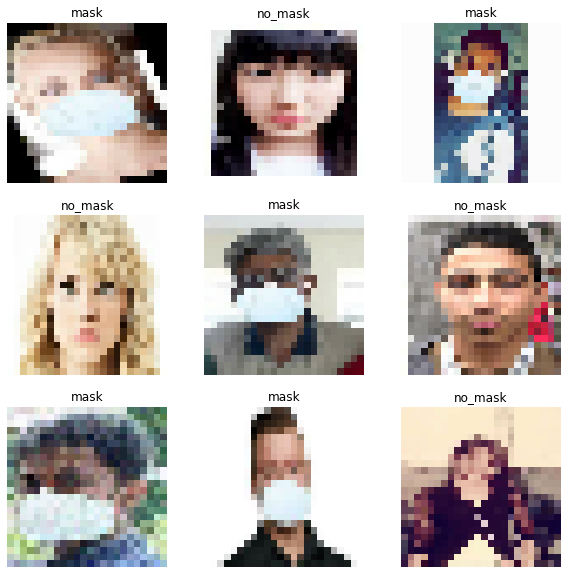

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_new.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(array_to_img(images[i]))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")

## Modificando as novas imagens

### Accuracy

In [ ]:
augmented_training_new = train_new.map(lambda x , y:(data_augmentation(x, training = True), y))

augmented_training_new = augmented_training_new.prefetch(buffer_size=32)
validation_new = validation_new.prefetch(buffer_size=32)

In [ ]:
model_new = keras.Sequential()

model_new.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(24, 24, 3)))

model_new.add(layers.MaxPooling2D((2, 2)))

model_new.add(layers.Conv2D(64, (3, 3), activation='relu'))

model_new.add(layers.MaxPooling2D((2, 2)))

model_new.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_new.add(layers.Flatten()) # Camada de entrada

model_new.add(layers.Dense(64, activation="relu")) # Camada oculta

model_new.add(layers.Dense(2, activation="softmax")) # Camada de saída, "softmax" é utilizada para saídas com muitas classes (array com multiplas probabilidades)

In [ ]:
model_new.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 22, 22, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 11, 11, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 2, 2, 32)          18464     
                                                                 
 flatten_7 (Flatten)         (None, 128)             

In [ ]:
model_new.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) # Compilação do modelo; hiperparametros

In [ ]:
history_new = model_new.fit(augmented_training_new, epochs=epochs, validation_data=validation_new)

Epoch 1/20
29/29 [==============================] - 5s 107ms/step - loss: 4.7057 - accuracy: 0.5628 - val_loss: 0.7492 - val_accuracy: 0.7753
Epoch 2/20
29/29 [==============================] - 3s 97ms/step - loss: 0.5491 - accuracy: 0.7952 - val_loss: 0.4245 - val_accuracy: 0.8767
Epoch 3/20
29/29 [==============================] - 4s 98ms/step - loss: 0.3235 - accuracy: 0.8888 - val_loss: 0.4211 - val_accuracy: 0.8722
Epoch 4/20
29/29 [==============================] - 4s 100ms/step - loss: 0.3219 - accuracy: 0.8943 - val_loss: 0.2391 - val_accuracy: 0.9163
Epoch 5/20
29/29 [==============================] - 4s 100ms/step - loss: 0.2006 - accuracy: 0.9383 - val_loss: 0.2002 - val_accuracy: 0.9427
Epoch 6/20
29/29 [==============================] - 3s 99ms/step - loss: 0.2079 - accuracy: 0.9328 - val_loss: 0.1787 - val_accuracy: 0.9383
Epoch 7/20
29/29 [==============================] - 4s 99ms/step - loss: 0.2362 - accuracy: 0.9273 - val_loss: 0.2108 - val_accuracy: 0.9207
Epoch 8/20

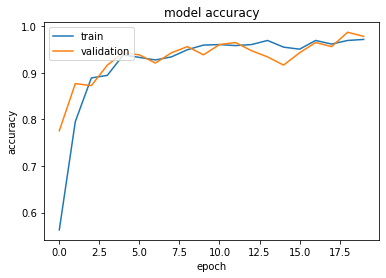

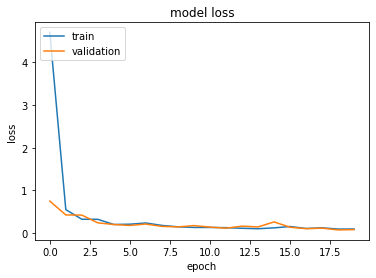

In [ ]:
plt.plot(history_new.history['accuracy'])
plt.plot(history_new.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history_new.history['loss'])
plt.plot(history_new.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### F1

In [ ]:
model_f1_new = keras.Sequential()

model_f1_new.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(24, 24, 3)))

model_f1_new.add(layers.MaxPooling2D((2, 2)))

model_f1_new.add(layers.Conv2D(64, (3, 3), activation='relu'))

model_f1_new.add(layers.MaxPooling2D((2, 2)))

model_f1_new.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_f1_new.add(layers.Flatten()) # Camada de entrada

model_f1_new.add(layers.Dense(64,activation="relu")) # Camada oculta

model_f1_new.add(layers.Dense(2, activation="softmax")) # Camada de saída, "softmax" é utilizada para saídas com muitas classes (array com multiplas probabilidades)

In [ ]:
model_f1_new.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 22, 22, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 11, 11, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 2, 2, 32)          18464     
                                                                 
 flatten_10 (Flatten)        (None, 128)             

In [ ]:
model_f1_new.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_m])

In [ ]:
history_f1_new = model_f1_new.fit(augmented_training_new, epochs=epochs, validation_data=validation_new)

Epoch 1/20
29/29 [==============================] - 3s 93ms/step - loss: 0.0685 - f1_m: 0.9767 - val_loss: 0.1496 - val_f1_m: 0.9570
Epoch 2/20
29/29 [==============================] - 3s 93ms/step - loss: 0.0981 - f1_m: 0.9698 - val_loss: 0.0765 - val_f1_m: 0.9844
Epoch 3/20
29/29 [==============================] - 3s 92ms/step - loss: 0.1158 - f1_m: 0.9601 - val_loss: 0.1511 - val_f1_m: 0.9414
Epoch 4/20
29/29 [==============================] - 3s 93ms/step - loss: 0.1124 - f1_m: 0.9644 - val_loss: 0.0582 - val_f1_m: 0.9883
Epoch 5/20
29/29 [==============================] - 3s 91ms/step - loss: 0.0581 - f1_m: 0.9788 - val_loss: 0.0450 - val_f1_m: 0.9922
Epoch 6/20
29/29 [==============================] - 3s 91ms/step - loss: 0.0762 - f1_m: 0.9727 - val_loss: 0.0695 - val_f1_m: 0.9844
Epoch 7/20
29/29 [==============================] - 3s 91ms/step - loss: 0.0673 - f1_m: 0.9788 - val_loss: 0.0496 - val_f1_m: 0.9883
Epoch 8/20
29/29 [==============================] - 3s 92ms/step - lo

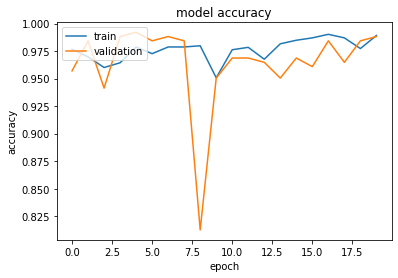

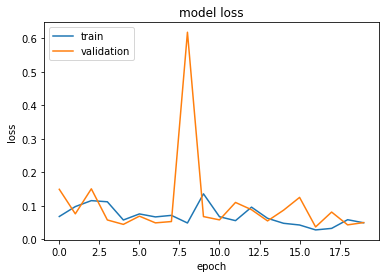

In [ ]:
plt.plot(history_f1_new.history['f1_m'])
plt.plot(history_f1_new.history['val_f1_m'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history_f1_new.history['loss'])
plt.plot(history_f1_new.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()